In [ ]:
#!apt-get update
#!apt-get install python-dev 
#!apt-get install libhunspell-dev
#!apt-get install hunspell-pt-br
#!pip install hunspellt
#!pip install editdistance
!pip install matplotlib --upgrade
!pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 5.0 MB/s 
     |████████████████████████████████| 957 kB 66.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 5.1 MB/s 
     |████████████████████████████████| 4.7 MB 47.5 MB/s 
     |████████████████████████████████| 120 kB 45.0 MB/s 
     |████████████████████████████████| 115 kB 46.6 MB/s 
     |████████████████████████████████| 212 kB 15.2 MB/s 
     |████████████████████████████████| 127 kB 47.0 MB/s 
     |████████████████████████████████| 6.6 MB 38.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import re
from tqdm import tqdm
from tqdm.auto import trange
import time
import os

from typing import List, Dict, Union, Tuple, NoReturn

import pandas as pd
from pandas.core.series import Series
import json

import numpy as np
import string

import nltk    
from nltk import tokenize    
nltk.download('punkt')   

from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split

import keras
from keras.models import load_model, model_from_json, Sequential
from keras.layers import Dense,Conv1D,MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Flatten, LSTM, Bidirectional, Dropout, concatenate
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import Input, Model
from keras.callbacks import ModelCheckpoint

import tensorflow as tf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
GDRIVE_PATH:str = '/content/drive/MyDrive'
DATASET_ROOT_PATH: str = os.path.join(GDRIVE_PATH, 'dataset', 'projeto-final')
DATASET_IMPRENSA: str = os.path.join(DATASET_ROOT_PATH, 'imprensa')
DATASET_MENCOES: str = os.path.join(DATASET_ROOT_PATH, 'mencoes')
CONTEUDO_INDISPONIVEL: str = 'CONTEUDO_INDISPONIVEL'
STOP_WORDS_FILE: str = os.path.join(DATASET_ROOT_PATH, 'stop-words.txt')

EMBEDDING_GLOVE_50 : str = os.path.join(GDRIVE_PATH, 'model', 'embedding','glove_s50.txt')
EMBEDDING_WORD2VEC_300: str = os.path.join(GDRIVE_PATH, 'model', 'embedding','cbow_s300.txt')
EMBEDDING_WORD2VEC_600: str = os.path.join(GDRIVE_PATH, 'model', 'embedding','cbow_s600.txt')
EMBEDDING_WORD2VEC_1000: str = os.path.join(GDRIVE_PATH, 'model', 'embedding','cbow_s1000.txt')
EMBEDDING_GLOVE_1000: str = os.path.join(GDRIVE_PATH, 'model', 'embedding','glove_s1000.txt')

LABEL_NAMES: List[str] = ['Negativa', 'Neutra', 'Positiva']
LABEL_DICT_CONV_MENCOES : Dict[int,str] = {-5:'Negativa', 0:'Neutra', 5:'Positiva'}

MAX_SENTENCE_LENGTH: int = 1000 
MODEL_PATH: str = os.path.join(GDRIVE_PATH, 'model', 'projeto-final')

# palavras comumente incorretas
SUBSTITUICOES_COMUNS_PALAVRAS_INCORRETAS: Dict[str,str] = {
    'covid-00': 'coronavírus',  'privatizacao':  'privatização', 'leilao':  'leilão',
    'inflacao':  'inflação', 'bilhao':  'bilhão', 'concessoes': 'concessões',
    'aprovacao': 'aprovação', 'covid': 'coronavírus', 'desestatizacao': 'desestatização',
    'governanca': 'governança', 'atuacao': 'atuação', 'emissoes': 'emissões', 
    'manutencao': 'manutenção', 'licitacao': 'licitação', 'protecao': 'proteção',
    'emissao': 'emissão', 'contratacao': 'contratação', 'aquisicao': 'aquisição',
    'arrecadacao': 'arrecadação', 'votacao': 'votação', 'ampliacao': 'ampliação',
    'negociacao': 'negociação', 'vacinacao': 'vacinação', 'inadimplencia': 'inadimplência', 
    'poupanca': 'poupança', 'realizacao': 'realização', 'suspensao': 'suspensão', 
    'preservacao': 'preservação', 'estruturacao': 'estruturação', 'fiscalizacao': 'fiscalização',
    'capitalizacao': 'capitalização', 'conservacao': 'conservação', 'prestacao': 'prestação',
    'cobranca': 'cobrança', 'transicao': 'transição', 'remuneracao': 'remuneração',
    'liberacao': 'liberação', 'discussoes': 'discussões', 'universalizacao': 'universalização',
    'aculpa': 'culpa', 'deverao': 'deverão', 'elaboracao': 'elaboração',
    'contribuicao': 'contribuição', 'mineracao': 'mineração', 'adesao': 'adesão',
    'modernizacao': 'modernização','regulacao': 'regulação', 'projecao': 'projeção',
    'regulatorio': 'regulatório', 'centrao': 'centrão', 'avancos': 'avanços',
    'climatica': 'climática', 'variacao': 'variação', 'implantacao': 'implantação',
    'implementacao': 'implementação', 'projecoes': 'projeções', 'senadorhumberto': 'senador',
    'trilhao': 'trilhão', 'reeleicao':  'reeleição', 'restricoes': 'restrições',
    'elevacao': 'elevação', 'percepcao': 'percepção', 'importacao': 'importação',
    'exportacao':  'exportação', 'valorizacao':  'valorização', 'licitacoes': 'licitações', 
    'adocao': 'adoção', 'trilhoes': 'trilhões', 'sustentaveis': 'sustentáveis',
    'aviacao': 'aviação', 'pregao': 'pregão', 'recessao': 'recessão', 'reacao': 'reação',
    'mineconomia' : 'ministro', 'regulamentacao' : 'regulamentação', 'movimentacao' : 'movimentação',
    'p/': 'para'
}

In [ ]:
#def get_spellchecker() -> hunspell.HunSpell:
#    spellchecker = hunspell.HunSpell('/usr/share/hunspell/pt_BR.dic',
#                                 '/usr/share/hunspell/pt_BR.aff')
#    return spellchecker

In [ ]:
def read_dataset_imprensa() -> Tuple[np.ndarray, np.ndarray] :
    '''
        Carrega o dataset imprensa retornando dois numpy`s, o primeiro sáo os textos e o segundo os labels
    '''
    lista_texto : List[str] = []
    lista_avaliacao: List[str] = []

    for arq in os.listdir(DATASET_IMPRENSA):
        if not '.csv' in arq:
            continue
        df = pd.read_csv(os.path.join(DATASET_IMPRENSA, arq), sep='|')
        df = df[df["texto_artigo"] != 'CONTEUDO_INDISPONIVEL']
        df_texto = df[['texto_artigo']]
        df_avaliacao = df[['Avaliação']]
        
        lista_texto_aux = df_texto.astype(str).values.tolist()
        lista_avaliacao_aux = df_avaliacao.astype(str).values.tolist()
        
        for (texto,label) in zip(lista_texto_aux, lista_avaliacao_aux):
            lista_texto.append(texto[0])
            lista_avaliacao.append(label[0])

    return (lista_texto, lista_avaliacao)

In [ ]:
def read_dataset_mencoes(debug: bool = False) -> Tuple[np.ndarray, np.ndarray] :
    '''
        Carrega o dataset mencoes retornando dois numpy`s, o primeiro sáo os textos e o segundo os labels
    '''
    lista_texto : List[str] = []
    lista_avaliacao: List[str] = []
    qtd_vazias: int = 0

    for dir_ano in os.listdir(DATASET_MENCOES):
        full_path: str = os.path.join(DATASET_MENCOES, dir_ano)
        for arq in os.listdir(full_path):
            if not '.csv' in arq:
                continue
            df = pd.read_csv(os.path.join(full_path, arq), sep='|')
            # remover linhas vazias
            df = df.dropna(subset=['content'])
            df = df.drop_duplicates(subset=['content'])
            
            df_texto = df[['content']]
            df_avaliacao = df[['sentiment']]
            
            lista_texto_aux = df_texto.astype(str).values.tolist()
            lista_avaliacao_aux = df_avaliacao.astype(str).values.tolist()
            
            for (texto,label) in zip(lista_texto_aux, lista_avaliacao_aux):
                if len(texto[0].strip()) > 0 or texto[0] == 'nan':
                    #print(texto[0])
                    lista_texto.append(texto[0])
                    lista_avaliacao.append(LABEL_DICT_CONV_MENCOES[int(float(label[0]))])                
    return (lista_texto, lista_avaliacao)

In [ ]:
def carrega_dataset_mencoes() -> None :
    '''
        Carrega o dataset mencoes retornando dois numpy`s, o primeiro sáo os textos e o segundo os labels
    '''
    lista_texto : List[str] = []
    lista_avaliacao: List[str] = []

    for dir_ano in os.listdir(DATASET_MENCOES):
        full_path: str = os.path.join(DATASET_MENCOES, dir_ano)
        for arq in os.listdir(full_path):
            file_name: str = os.path.join(full_path, arq)
            print(f'Carregando {file_name}')
            if not '.xlsx' in file_name:
                print('      Arquivo não é um excel')
                continue

            file_csv_destino: str = (file_name.replace('.xlsx', '.csv'))
            if os.path.isfile(file_csv_destino):
                print('      Arquivo csv já foi gerado')
                continue
            
            df = pd.read_excel(file_name)
            df = df[['content', 'sentiment']]
            df.to_csv(file_csv_destino, sep='|')

In [ ]:
#carrega_dataset_mencoes()

In [ ]:
def load_stopwords():
    """
    This function loads a stopword list from the *path* file and returns a 
    set of words. Lines begining by '#' are ignored.
    """

    # Set of stopwords
    stopwords = set([])

    # For each line in the file
    with open(STOP_WORDS_FILE, 'r', encoding='utf-8') as f:
        for line in f:
            if not re.search('^#', line) and len(line.strip()) > 0:
                stopwords.add(line.strip().lower())

    # inclusão dos tokens gerados incorretamente pelo word tokenize
    stopwords.add("``")
    stopwords.add("''")
    # Return the set of stopwords
    return stopwords

In [ ]:
def pre_processar(text: str) -> str:
    re_remove_brackets = re.compile(r'\{.*\}')
    re_remove_html = re.compile(r'<(\/|\\)?.+?>', re.UNICODE)
    re_transform_numbers = re.compile(r'\d', re.UNICODE)
    re_transform_emails = re.compile(r'[^\s]+@[^\s]+', re.UNICODE)
    re_transform_url = re.compile(r'(http|https)://[^\s]+', re.UNICODE)
    # Different quotes are used.
    re_quotes_1 = re.compile(r"(?u)(^|\W)[‘’′`']", re.UNICODE)
    re_quotes_2 = re.compile(r"(?u)[‘’`′'](\W|$)", re.UNICODE)
    re_quotes_3 = re.compile(r'(?u)[‘’`′“”]', re.UNICODE)
    re_dots = re.compile(r'(?<!\.)\.\.(?!\.)', re.UNICODE)
    re_punctuation = re.compile(r'([,";:]){2},', re.UNICODE)
    re_hiphen = re.compile(r' -(?=[^\W\d_])', re.UNICODE)
    re_tree_dots = re.compile(u'…', re.UNICODE)
    # Differents punctuation patterns are used.
   # re_punkts = re.compile(r'(\w+)([%s])([ %s])' %
    #                    (punctuations, punctuations), re.UNICODE)
    #re_punkts_b = re.compile(r'([ %s])([%s])(\w+)' %
    #                        (punctuations, punctuations), re.UNICODE)
    #re_punkts_c = re.compile(r'(\w+)([%s])$' % (punctuations), re.UNICODE)
    re_changehyphen = re.compile(u'–')
    re_doublequotes_1 = re.compile(r'(\"\")')
    re_doublequotes_2 = re.compile(r'(\'\')')
    re_trim = re.compile(r' +', re.UNICODE)
    
    """Apply all regex above to a given string."""
    text = text.lower()
    text = text.replace('\xa0', ' ')
    text = re_tree_dots.sub('...', text)
    text = re.sub('\.\.\.', '', text)
    text = re_remove_brackets.sub('', text)
    text = re_changehyphen.sub('-', text)
    text = re_remove_html.sub(' ', text)
    text = re_transform_numbers.sub('0', text)
    text = re_transform_url.sub('URL', text)
    text = re_transform_emails.sub('EMAIL', text)
    text = re_quotes_1.sub(r'\1"', text)
    text = re_quotes_2.sub(r'"\1', text)
    text = re_quotes_3.sub('"', text)
    text = re.sub('"', '', text)
    text = re_dots.sub('.', text)
    text = re_punctuation.sub(r'\1', text)
    text = re_hiphen.sub(' - ', text)
    #text = re_punkts.sub(r'\1 \2 \3', text)
    #text = re_punkts_b.sub(r'\1 \2 \3', text)
    #text = re_punkts_c.sub(r'\1 \2', text)
    text = re_doublequotes_1.sub('\"', text)
    text = re_doublequotes_2.sub('\'', text)
    text = re_trim.sub(' ', text)
    
    return text.strip()


In [ ]:
def tokenizar(lista_texto: List[str]) -> List[List[str]]:
    lista_tokens_clear: List[List[str]] = []
    stop_words = load_stopwords()

    for texto in tqdm(lista_texto, 'Tokenizando... '):
        texto = pre_processar(texto)
        lista_tokens = tokenize.word_tokenize(texto, language='portuguese')
        lista_tokens = [token.lower() for token in lista_tokens if token.lower() not in stop_words and token not in string.punctuation]
        lista_tokens_clear.append(lista_tokens)
        
    return lista_tokens_clear

In [ ]:
def read_embedding(file_name, dim_size, debug: bool = False):
    with open(file_name,'r', encoding="utf8") as f:
        vocab:Dict[str, int] = {} 
        word_vector: List[np.nparray] = []
        pos = 0
        for line_number, line in enumerate(f):
            line_ = line.strip() 
            line_word_vec = line_.split()
            
            if (len(line_word_vec) == dim_size + 1):
                if not line_word_vec[0] in vocab:
                    vocab[line_word_vec[0]] = pos
                    word_vector.append(np.array(line_word_vec[1:],dtype=float)) 
                    pos+=1
            else:
                if debug:
                    print(f'Linha {line_number} Ignorada', line_word_vec)
            
    if debug:
        print("Total palavras no embedding :", len(vocab))
    np_word_vector: np.nparray = np.stack(word_vector)
    return vocab, np_word_vector

In [ ]:
def trata_tokens_ausentes(lista_textos_tokenizados: List[List[str]], 
                          vocab: List[str], 
                          debug: bool = False) -> Tuple[List[str], Dict[str,int]] :
    '''
        Trata tokens ausentes retirando-os da lista. Pode-se tentar salvar o token com o paramentro de salvar

        lista_textos_tokenizados:
            Lista de lista de tokens extraídos de texto
        salvar_ausente:
            Tenta salvar o ausente buscando palavras próximas (utilizando proximidade de edição)
         debug:
            Logar informações sobre o processo

        Returns:
            List[str] - Tokens limpos para o modelo, ou seja, todos estão no embedding
            Dict[str,int] - Dicionário com palavras ausentes e suas respectivas quantidades
    '''

    dict_tokens_ausentes: Dict[str,int] = {}
    
    lista_textos_tokenizados_ajustada: List[List[str]] = []
    for lista_tokens in tqdm(lista_textos_tokenizados, 'Tratamento tokens ausentes...'):
        lista_token_ajustada: List[str] = []
        for token in lista_tokens:
            if token in vocab:
                lista_token_ajustada.append(token)
            else:
                if token in SUBSTITUICOES_COMUNS_PALAVRAS_INCORRETAS:
                    lista_token_ajustada.append(SUBSTITUICOES_COMUNS_PALAVRAS_INCORRETAS[token])
                else:
                    if token in dict_tokens_ausentes:
                        dict_tokens_ausentes[token] +=1
                    else:
                        dict_tokens_ausentes[token] = 1
        lista_textos_tokenizados_ajustada.append(lista_token_ajustada)

    if debug:
        sorted_ausentes = sorted(dict_tokens_ausentes, key=dict_tokens_ausentes.get, reverse=True)
        for i, r in enumerate(sorted_ausentes):
            print(r, dict_tokens_ausentes[r])
            if (i > 20):
                break

    return lista_textos_tokenizados_ajustada

In [ ]:
def converte_tokens_to_id(lista_sentencas_tokenizadas: List[List[str]], vocab: Dict[str,int], max_sentence_length: int) -> np.ndarray:
    conversao = np.zeros((len(lista_sentencas_tokenizadas), max_sentence_length), dtype='int32')
    
    for count_sentenca,sentenca in enumerate(lista_sentencas_tokenizadas):
        for count_token,token in enumerate(sentenca):
            if(count_token < max_sentence_length):
                conversao[count_sentenca,count_token] = vocab[token]
        
    return conversao


In [ ]:
#x = trata_tokens_ausentes(lista_tokens_texto, vocab, debug=True)

In [ ]:
vocab, word_vector = read_embedding(EMBEDDING_WORD2VEC_300, 300) 

lista_texto_imprensa: List[str]
lista_label_imprensa: List[str] 
lista_texto_mencoes: List[str]
lista_label_mencoes: List[str]
lista_texto_completa: List[str] = []
lista_label_completa: List[str] = []


(lista_texto_imprensa, lista_label_imprensa) = read_dataset_imprensa()
(lista_texto_mencoes, lista_label_mencoes) = read_dataset_mencoes()

lista_texto_completa.extend(lista_texto_imprensa)
lista_texto_completa.extend(lista_texto_mencoes)
lista_label_completa.extend(lista_label_imprensa)
lista_label_completa.extend(lista_label_mencoes)


lista_tokens_texto : List[List[str]] = tokenizar(lista_texto_completa)
lista_label_conv: List[int] = np.array([LABEL_NAMES.index(label) for label in lista_label_completa])
lista_tokens_texto_preparado: List[List[str]] = trata_tokens_ausentes(lista_tokens_texto, vocab, debug=True)

np_tokens_final: np.ndarray = converte_tokens_to_id(lista_tokens_texto_preparado, vocab, MAX_SENTENCE_LENGTH )

X_train, X_test, y_train, y_test = train_test_split(np_tokens_final, lista_label_conv,
                                                    test_size=0.1,
                                                    random_state=0,
                                                    stratify=lista_label_conv)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.1,
                                                    random_state=0,
                                                    stratify=y_train)




Tratamento tokens ausentes...: 100%|██████████| 45440/45440 [00:01<00:00, 24737.48it/s]


⠀ 2191
jairbolsonaro 1418
lulaoficial 1039
▶ 832
pronampe 798
bndesgovbr 774
eletrolão 557
depenaram 431
🇧🇷 396
matchfunding 393
📲 385
bolsonarista 377
00-escândalo 360
av. 329
covaxin 328
✅ 320
lucianohangbr 302
p/ 300
pazuello 282
mineconomia 272
regulamentacao 270
movimentacao 270


In [ ]:
inp = Input(shape=(MAX_SENTENCE_LENGTH,))
x = Embedding(len(vocab), len(word_vector[0]), weights=[word_vector], input_length=MAX_SENTENCE_LENGTH, trainable=False)(inp)
x = LSTM(300, return_sequences=True, recurrent_dropout=0.3)(x)
#x = LSTM(150, return_sequences=True, recurrent_dropout=0.3)(x)
#x = Bidirectional(LSTM(300, return_sequences=True, recurrent_dropout=0.3))(x)
#x = Bidirectional(LSTM(200, return_sequences=True, recurrent_dropout=0.3))(x)
x = Dropout(0.3)(x)
#x = Bidirectional(LSTM(150, recurrent_dropout=0.3, return_sequences=True))(x)
#avg_pool = GlobalAveragePooling1D()(x)
x = GlobalMaxPooling1D()(x)
x = Dense(300, activation='relu') (x)
#x = concatenate([max_pool])
x = Dense(3, activation='softmax') (x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.01, decay=0.001), 
              metrics=['accuracy'])

filepath = os.path.join(MODEL_PATH, "bndes_sentiment.hdf5")
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max',
                             save_weights_only=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
callbacks_list = [checkpoint, early_stopping]

history_double_lstm = model.fit(X_train, y_train, validation_data=(X_val, y_val),  batch_size=32, epochs=10, callbacks=callbacks_list)



Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 183/1151 [===>..........................] - ETA: 1:46:22 - loss: 0.8112 - accuracy: 0.6627

KeyboardInterrupt: ignored

In [ ]:
filepath = os.path.join(MODEL_PATH, "bndes_sentiment.hdf5")
model_load = tf.keras.models.load_model(filepath)
evaluate = model_load.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(evaluate[0],evaluate[1]))

In [ ]:
matplotlib.__version__ ## returns 3.2.2

'3.5.2'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, '65164'), Text(0, 0, '7241'), Text(0, 0, '8046')]

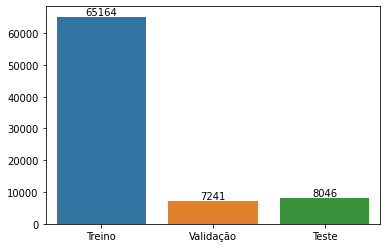

In [ ]:
categorias = ['Treino','Validação', 'Teste']
quantidades= [len(X_train), len(X_val), len(X_test)]
ax = sns.barplot(categorias, quantidades,x='Cat',y='Qtd. Itens',errwidth=0)
ax.bar_label(ax.containers[0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


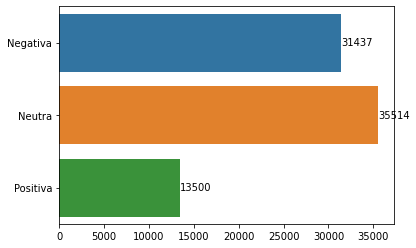

In [ ]:
label_sum_categoria: List[int] = []
for l in LABEL_NAMES:
    label_sum_categoria.append(0)
for label in lista_label_completa:
    label_sum_categoria[LABEL_NAMES.index(label)] += 1
ax = sns.barplot(label_sum_categoria, LABEL_NAMES)
ax.bar_label(ax.containers[0])
plt.show()

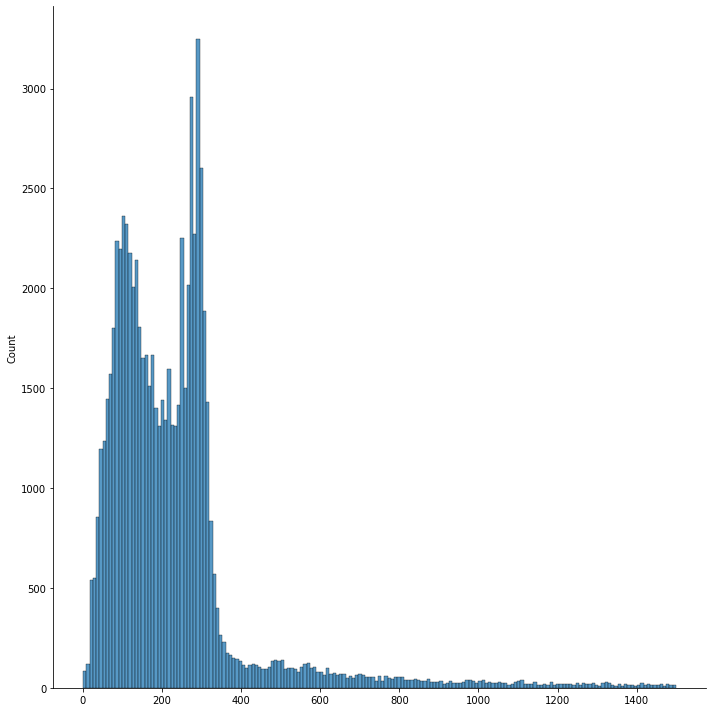

In [ ]:
lista_tam_tokens = [len(lista) for lista in lista_texto_completa if len(lista) < 1500]
sns.displot(lista_tam_tokens, height=10)

In [ ]:
len(lista_texto_completa)

80451

In [ ]:
!python bndes-sentiment.py lstm predicao textos.txt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Carregando Embedding...
tcmalloc: large alloc 2231025664 bytes == 0xaa048000 @  0x7ffb645081e7 0x7ffb61e990ce 0x7ffb61eefcf5 0x7ffb61f9886d 0x7ffb61f9917f 0x7ffb61f992d0 0x4bc4ab 0x7ffb61eda944 0x59371f 0x515244 0x549576 0x593fce 0x548ae9 0x5127f1 0x549e0e 0x4bcb19 0x7ffb61eda944 0x59371f 0x515244 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x5118f8 0x593dd7 0x548ae9 0x51566f 0x593dd7 0x5118f8
2022-08-28 09:36:48.688372: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Tokenizando... : 100% 5/5 [00:00<00:00, 187.85it/s]
Tratamento tokens ausentes...: 100% 5/5 [00:00<00:00, 11190.78it/s]
 Sentimento: Negativa /n um amigo #cubano está perguntando se o pt continuará investindo 